# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

C:\Users\Aldo\models\research\object_detection\utils\visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\Aldo\AppData\Local\conda\conda\envs\carnd-term1\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Aldo\AppData\Local\conda\conda\envs\carnd-term1\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Aldo\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Aldo\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  Fi

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [5]:
# What model to download.
#MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
#MODEL_NAME = 'ssd_mobilenet_v1_coco_2018_01_28'
#MODEL_NAME = 'ssd_inception_v2_coco'
MODEL_NAME = 'ssd_inception_v2_coco_bosch'
#MODEL_NAME = 'ssdlite_mobilenet_v2_coco_2018_05_09'
#MODEL_NAME = 'faster_rcnn_inception_v2_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'TL_label_map.pbtxt')

NUM_CLASSES = 3

## Download Model

In [85]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

HTTPError: HTTP Error 403: Forbidden

## Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [8]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [9]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [10]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 6) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [11]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

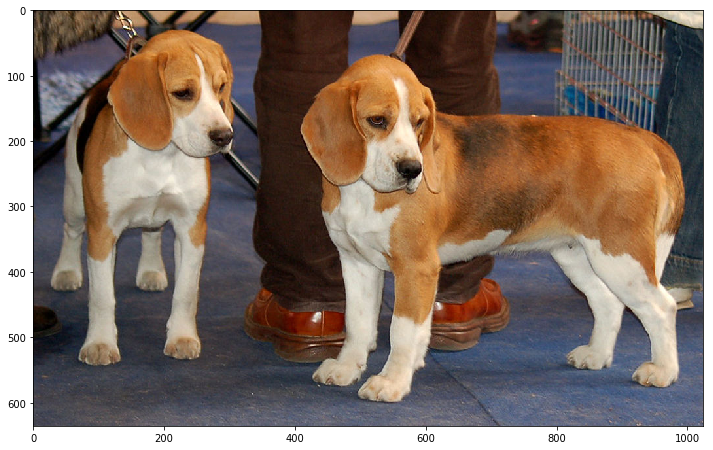

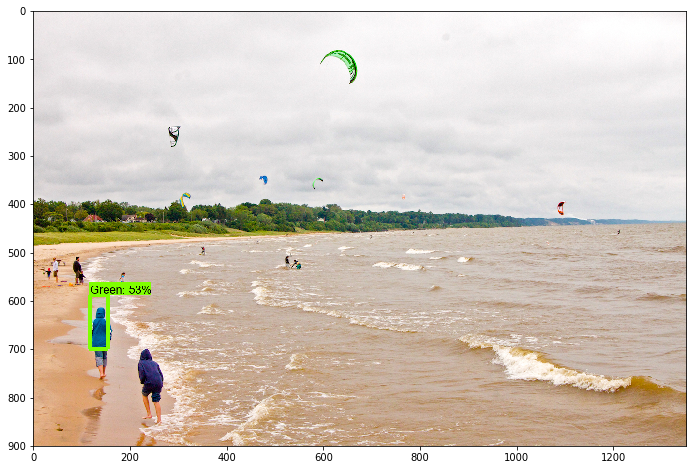

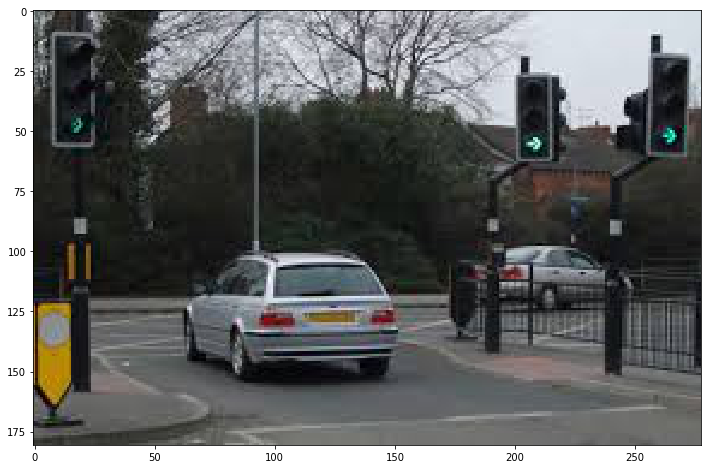

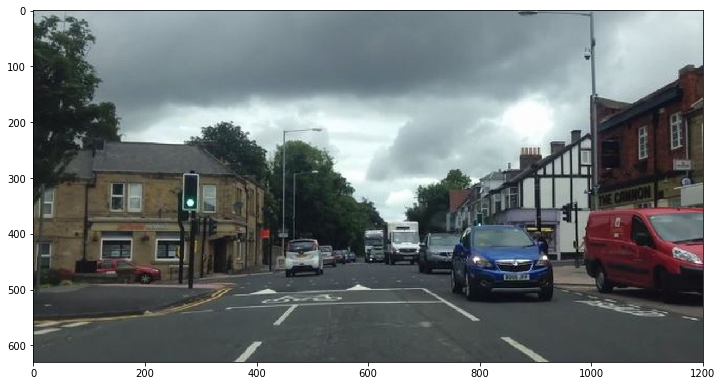

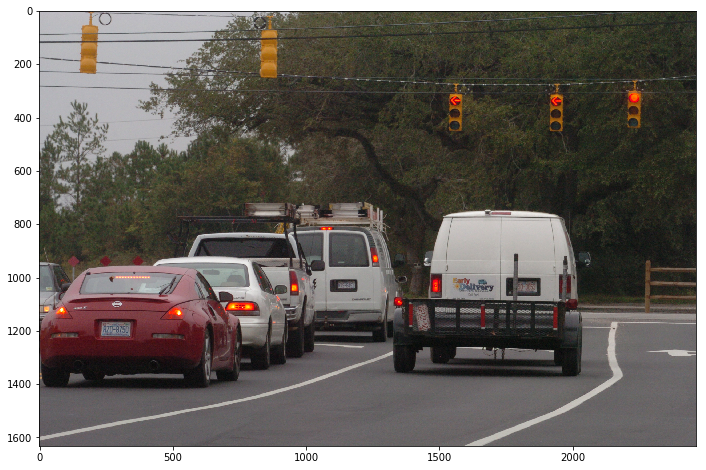

In [12]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

In [106]:
import tensorflow as tf
import yaml
import os
from object_detection.utils import dataset_util


In [107]:
def create_tf_example(example):
    
    # Bosch
    height = 720 # Image height
    width = 1280 # Image width

    filename = example['path'] # Filename of the image. Empty if image is not from file
    filename = filename.encode()

    with tf.gfile.GFile(example['path'], 'rb') as fid:
        encoded_image = fid.read()

    image_format = 'png'.encode() 

    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box
                # (1 per box)
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box
                # (1 per box)
    classes_text = [] # List of string class name of bounding box (1 per box)
    classes = [] # List of integer class id of bounding box (1 per box)

    for box in example['boxes']:
        #if box['occluded'] is False:
        #print("adding box")
        xmins.append(float(box['x_min'] / width))
        xmaxs.append(float(box['x_max'] / width))
        ymins.append(float(box['y_min'] / height))
        ymaxs.append(float(box['y_max'] / height))
        classes_text.append(box['label'].encode())
        classes.append(int(LABEL_DICT[box['label']]))


    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_image),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))

    return tf_example

In [109]:
LABEL_DICT =  {
    "Green" : 1,
    "Red" : 2,
    "GreenLeft" : 3,
    "GreenRight" : 4,
    "RedLeft" : 5,
    "RedRight" : 6,
    "Yellow" : 7,
    "off" : 8,
    "RedStraight" : 9,
    "GreenStraight" : 10,
    "GreenStraightLeft" : 11,
    "GreenStraightRight" : 12,
    "RedStraightLeft" : 13,
    "RedStraightRight" : 14
    }
    
#writer = tf.python_io.TFRecordWriter('data/training.record')
writer = tf.python_io.TFRecordWriter('data/testing.record')

# BOSCH datasets
#INPUT_YAML = "data/dataset_train_rgb/train.yaml"
INPUT_YAML = "data/dataset_test_rgb/test.yaml"
examples = yaml.load(open(INPUT_YAML, 'rb').read())

#examples = examples[:10]  # for testing
len_examples = len(examples)
print("Loaded ", len(examples), "examples")

for i in range(len(examples)):
    examples[i]['path'] = os.path.abspath(os.path.join(os.path.dirname(INPUT_YAML), examples[i]['path']))

counter = 0
for example in examples:
    tf_example = create_tf_example(example)
    writer.write(tf_example.SerializeToString())

    if counter % 10 == 0:
        print("Percent done", (counter/len_examples)*100)
    counter += 1

writer.close()

Loaded  8334 examples
Percent done 0.0
Percent done 0.11999040076793857
Percent done 0.23998080153587714
Percent done 0.3599712023038157
Percent done 0.4799616030717543
Percent done 0.5999520038396928
Percent done 0.7199424046076314
Percent done 0.8399328053755699
Percent done 0.9599232061435086
Percent done 1.079913606911447
Percent done 1.1999040076793857
Percent done 1.319894408447324
Percent done 1.4398848092152627
Percent done 1.5598752099832014
Percent done 1.6798656107511398
Percent done 1.7998560115190785
Percent done 1.9198464122870171
Percent done 2.0398368130549556
Percent done 2.159827213822894
Percent done 2.279817614590833
Percent done 2.3998080153587713
Percent done 2.51979841612671
Percent done 2.639788816894648
Percent done 2.759779217662587
Percent done 2.8797696184305255
Percent done 2.9997600191984644
Percent done 3.119750419966403
Percent done 3.2397408207343417
Percent done 3.3597312215022797
Percent done 3.479721622270218
Percent done 3.599712023038157
Percent do

Percent done 31.197504199664028
Percent done 31.317494600431967
Percent done 31.437485001199907
Percent done 31.557475401967842
Percent done 31.67746580273578
Percent done 31.79745620350372
Percent done 31.91744660427166
Percent done 32.0374370050396
Percent done 32.15742740580754
Percent done 32.27741780657548
Percent done 32.39740820734342
Percent done 32.51739860811135
Percent done 32.63738900887929
Percent done 32.75737940964723
Percent done 32.87736981041517
Percent done 32.99736021118311
Percent done 33.117350611951046
Percent done 33.237341012718986
Percent done 33.357331413486925
Percent done 33.477321814254864
Percent done 33.5973122150228
Percent done 33.717302615790736
Percent done 33.837293016558675
Percent done 33.957283417326614
Percent done 34.07727381809455
Percent done 34.197264218862486
Percent done 34.317254619630425
Percent done 34.437245020398365
Percent done 34.557235421166304
Percent done 34.67722582193424
Percent done 34.79721622270218
Percent done 34.9172066234

Percent done 62.75497960163187
Percent done 62.87497000239981
Percent done 62.994960403167745
Percent done 63.114950803935685
Percent done 63.234941204703624
Percent done 63.35493160547156
Percent done 63.474922006239495
Percent done 63.59491240700744
Percent done 63.714902807775374
Percent done 63.83489320854332
Percent done 63.95488360931125
Percent done 64.0748740100792
Percent done 64.19486441084713
Percent done 64.31485481161508
Percent done 64.43484521238301
Percent done 64.55483561315096
Percent done 64.67482601391889
Percent done 64.79481641468684
Percent done 64.91480681545477
Percent done 65.0347972162227
Percent done 65.15478761699065
Percent done 65.27477801775858
Percent done 65.39476841852651
Percent done 65.51475881929446
Percent done 65.63474922006239
Percent done 65.75473962083034
Percent done 65.87473002159827
Percent done 65.99472042236621
Percent done 66.11471082313415
Percent done 66.23470122390209
Percent done 66.35469162467002
Percent done 66.47468202543797
Perce

Percent done 94.79241660667147
Percent done 94.9124070074394
Percent done 95.03239740820734
Percent done 95.15238780897528
Percent done 95.27237820974322
Percent done 95.39236861051116
Percent done 95.5123590112791
Percent done 95.63234941204703
Percent done 95.75233981281498
Percent done 95.87233021358291
Percent done 95.99232061435086
Percent done 96.11231101511879
Percent done 96.23230141588674
Percent done 96.35229181665467
Percent done 96.47228221742262
Percent done 96.59227261819055
Percent done 96.7122630189585
Percent done 96.83225341972643
Percent done 96.95224382049436
Percent done 97.0722342212623
Percent done 97.19222462203024
Percent done 97.31221502279817
Percent done 97.4322054235661
Percent done 97.55219582433405
Percent done 97.67218622510198
Percent done 97.79217662586993
Percent done 97.91216702663786
Percent done 98.0321574274058
Percent done 98.15214782817374
Percent done 98.27213822894169
Percent done 98.39212862970962
Percent done 98.51211903047756
Percent done 9